# Imports and data

In [1]:


import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
# set_global("cache_dir", "/Users/ahemf/mygit/facebook-hateful-memes/cache")
set_global("dataloader_workers", 8)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, dict2sampleList, run_simclr, load_stored_params
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, HalfSwap, get_transforms_for_bbox_methods
from facebook_hateful_memes_detector.preprocessing import get_transforms_for_multiview
from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset, ImageFolderDataset, ZipDatasets
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
from facebook_hateful_memes_detector.models.MultiModal import VilBertVisualBertModelV2, MLMSimCLR, MLMOnlyV2, make_plots
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
from facebook_hateful_memes_detector.utils import get_vgg_face_model, get_torchvision_classification_models, init_fc, my_collate, merge_sample_lists
reload(facebook_hateful_memes_detector)

devices = ["cuda:0", "cuda:0", "cuda:1", "cuda:2", "cuda:3",]
# devices = ["cpu"] * 5
device = torch.device(devices[0] if torch.cuda.is_available() else "cpu")
device1 = torch.device(devices[1] if torch.cuda.is_available() else "cpu")
device2 = torch.device(devices[2] if torch.cuda.is_available() else "cpu")
device3 = torch.device(devices[3] if torch.cuda.is_available() else "cpu")
device4 = torch.device(devices[4] if torch.cuda.is_available() else "cpu")

set_device(device)
print(get_device())

scheduler_init_fn = get_cosine_schedule_with_warmup()
scheduler_init_fn = get_constant_schedule_with_warmup()
set_global("gradient_clipping", 10)
# Use mixup in SSL training, Use UDA maybe
# os.path.join(get_global("models_dir"),)


cuda:0


In [2]:
import random
def get_preprocess_text():
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, "punctuation_continue": 0.5}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/hard_dab.csv")
    def process(text, **kwargs):
        text = translation(text, **kwargs)
        text = gibberish(text, **kwargs)
        return text
    return process

preprocess_text = get_preprocess_text()
def text_vec(texts, ids):
    return [preprocess_text(text, identifier=identifier) for text, identifier in zip(texts, ids)]

def get_views():
    image_views = get_transforms_for_multiview()
    def get_view(imv):
        
        imtrans = image_views[imv]
        def vip(images):
            return [imtrans(i) for i in images]

        def aug(sampleList):
            sampleList = dict2sampleList(sampleList, device=get_device())
            sampleList = sampleList.copy()
            sampleList.image = vip(sampleList.original_image)
            sampleList.text = text_vec(sampleList.original_text, sampleList.id)
            sampleList.mixup = [False] * len(sampleList.text)
            sampleList = sampleList.to(get_device())
            return sampleList
        return aug
    
    return [get_view(0), get_view(1), get_view(2)]

data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=None,
                    train_image_transform=None,
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)





In [3]:
import random
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.9], char_level)
    word_level = {"split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "punctuation_continue": 0.5}
    word_level = TextAugment([0.1, 0.9], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, "glove_twitter": 0.75,"word_cutout": 0.5,
                      "one_third_cut": 0.2, "half_cut":0.0, "part_select": 0.2, }
    sentence_level = TextAugment([0.1, 0.9], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv"
                                )
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, "punctuation_continue": 0.5}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/hard_dab.csv")
    def process(text, **kwargs):
        if random.random() < 0.2:
            text = sentence_level(text, **kwargs)
        else:
            text = translation(text, **kwargs)
        text = word_level(text, **kwargs)
        text = char_level(text, **kwargs)
        text = gibberish(text, **kwargs)
        return text
    return process

preprocess_text = get_preprocess_text()
def text_vec(texts, ids):
    return [preprocess_text(text, identifier=identifier) for text, identifier in zip(texts, ids)]

def get_views():
    image_views = get_transforms_for_multiview()
    def get_view(imv):
        
        imtrans = image_views[imv]
        def vip(images):
            return [imtrans(i) for i in images]

        def aug(sampleList):
            sampleList = dict2sampleList(sampleList, device=get_device())
            sampleList = sampleList.copy()
            sampleList.image = vip(sampleList.original_image)
            sampleList.text = text_vec(sampleList.original_text, sampleList.id)
            sampleList.mixup = [False] * len(sampleList.text)
            sampleList = sampleList.to(get_device())
            return sampleList
        return aug
    
    return [get_view(0), get_view(1), get_view(2)]

data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=preprocess_text,
                    train_image_transform=get_transforms_for_bbox_methods(),
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)






[==================================================] 100.0% 387.1/387.1MB downloaded


(12540, 4)

In [3]:
data["test"]["label"] = -1
data['test_unseen']["label"] = -1
dev_unseen = data['dev_unseen'].copy()
data['dev_unseen']["label"] = -1

df = pd.concat((data["train"],
                data['dev_unseen'],
                data["test"], data['test_unseen']))
df.shape


(12540, 4)

In [4]:
dataset = convert_dataframe_to_dataset(df, data["metadata"], True)

In [ ]:
model_params = dict(
    model_name={"lxmert": dict(dropout=0.1, gaussian_noise=0.02, feature_dropout=0.01), 
                "vilbert": dict(dropout=0.05, gaussian_noise=0.01, feature_dropout=0.01), 
                "visual_bert": dict(dropout=0.05, gaussian_noise=0.01, feature_dropout=0.01),
                "mmbt_region": dict(dropout=0.1, gaussian_noise=0.02, feature_dropout=0.01)},
    num_classes=2,
    gaussian_noise=0.01,
    dropout=0.1,
    word_masking_proba=0.125,
    featurizer="pass",
    final_layer_builder=fb_1d_loss_builder,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=96,
    n_tokens_out=96,
    n_layers=0,
    attention_drop_proba=0.0,
    loss="focal",
    dice_loss_coef=0.0,
    auc_loss_coef=0.0,
    bbox_swaps=0,
    bbox_copies=0,
    bbox_deletes=0,
    bbox_gaussian_noise=0.01,
    bbox_feature_dropout=0.0,
    bbox_dropout=0.0,
    view_transforms=get_views(),
    view_loss_weight=0.05,
    devices=dict(lxmert=device2, vilbert=device2, 
                 visual_bert=device3, mmbt_region=device4),
    finetune=False)

model_class = VilBertVisualBertModelV2
model = model_class(**model_params)
# model = model.to(get_device())




Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

In [ ]:
# torch.save(model.lxmert.state_dict(), os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth"))
model.lxmert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth")))

# torch.save(model.mmbt_region.state_dict(), os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth"))
model.mmbt_region.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth")))


# torch.save(model.visual_bert.state_dict(), os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth"))
model.visual_bert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth")))

# torch.save(model.vilbert.state_dict(), os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth"))
model.vilbert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth")))


# Unimodal MLM

In [ ]:
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBertV2 import positive, negative
mlm_model = MLMOnlyV2(model, 0.1, {1: negative, 0: positive}, None, mlm_loss_weight=0.05,)
mlm_model = mlm_model.to(get_device())
# mlm_model.load_state_dict(torch.load("mlm-model-v2.pth"))
# mlm_model.load_state_dict(torch.load("mlm-model-v2-view-1.pth"))
# mlm_model = mlm_model.to(get_device())


In [ ]:
# torch.save(mlm_model.state_dict(), "mlm-model-v2-view-1.pth")



In [ ]:

lr_strategy = {
    "finetune": True,
    "model": {
        "vilbert": {"finetune": True,},
        "visual_bert": {"finetune": True,},
        "mmbt_region": {"finetune": True,},
        "lxmert": {"finetune": True,},
    },
    "mlm": {"finetune": True},
}
epochs = 1
batch_size = 2
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=3e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)

_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates, _ = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=8, plot=True,
                                     sampling_policy=None, class_weights=None)




In [11]:
clean_memory()

In [10]:
cache_stats = get_global("cache_stats")
cache_stats['get_img_details']
cache_stats['get_lxmert_details']

Counter({'called': 2028,
         'hit': 1330,
         'key_error': 686,
         'read-return-none': 698,
         'compute': 686,
         'writes': 685,
         'write_exception': 2,
         'write_retries': 2,
         'read_exception': 24,
         'read_retries': 24,
         're-compute': 12,
         're-compute-cache-busy-no-write': 12})

Counter({'called': 2024,
         'hit': 1294,
         'key_error': 730,
         'read-return-none': 730,
         'compute': 730,
         'writes': 729,
         'write_exception': 2,
         'write_retries': 1})

In [ ]:
model_parameters = list(filter(lambda p: p.requires_grad, model.lxmert.parameters()))
params = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable Params = %s" % (params), "\n", model.lxmert)


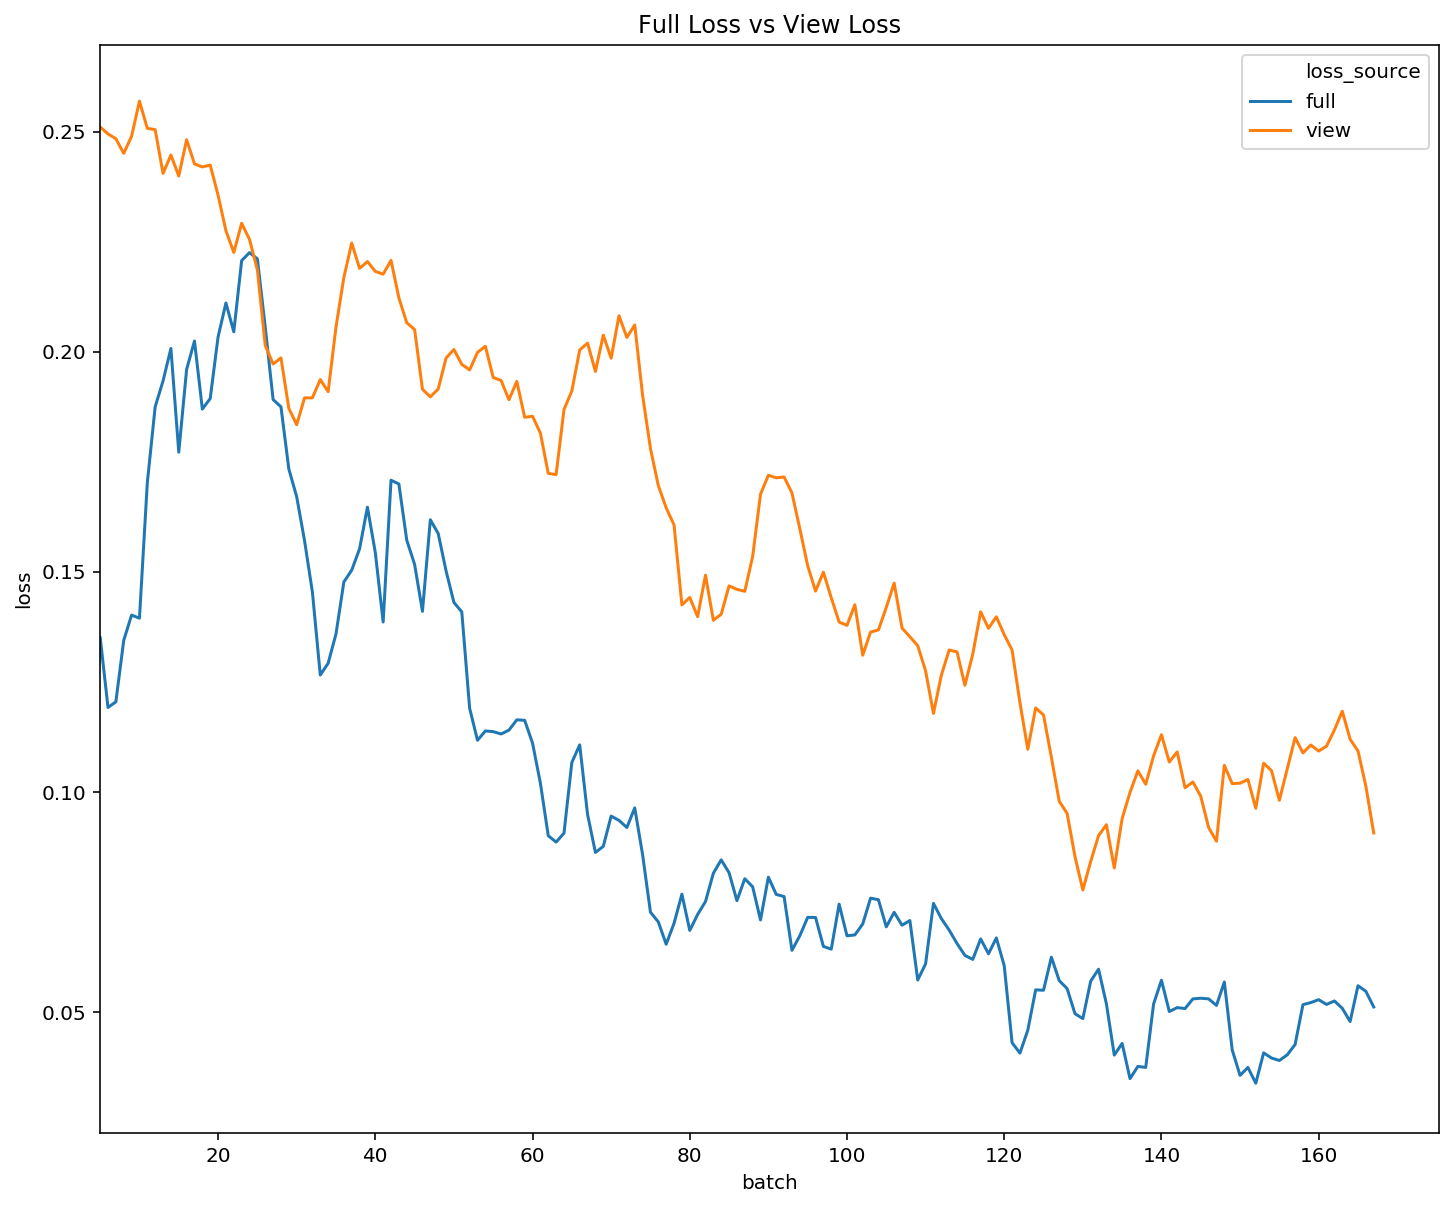

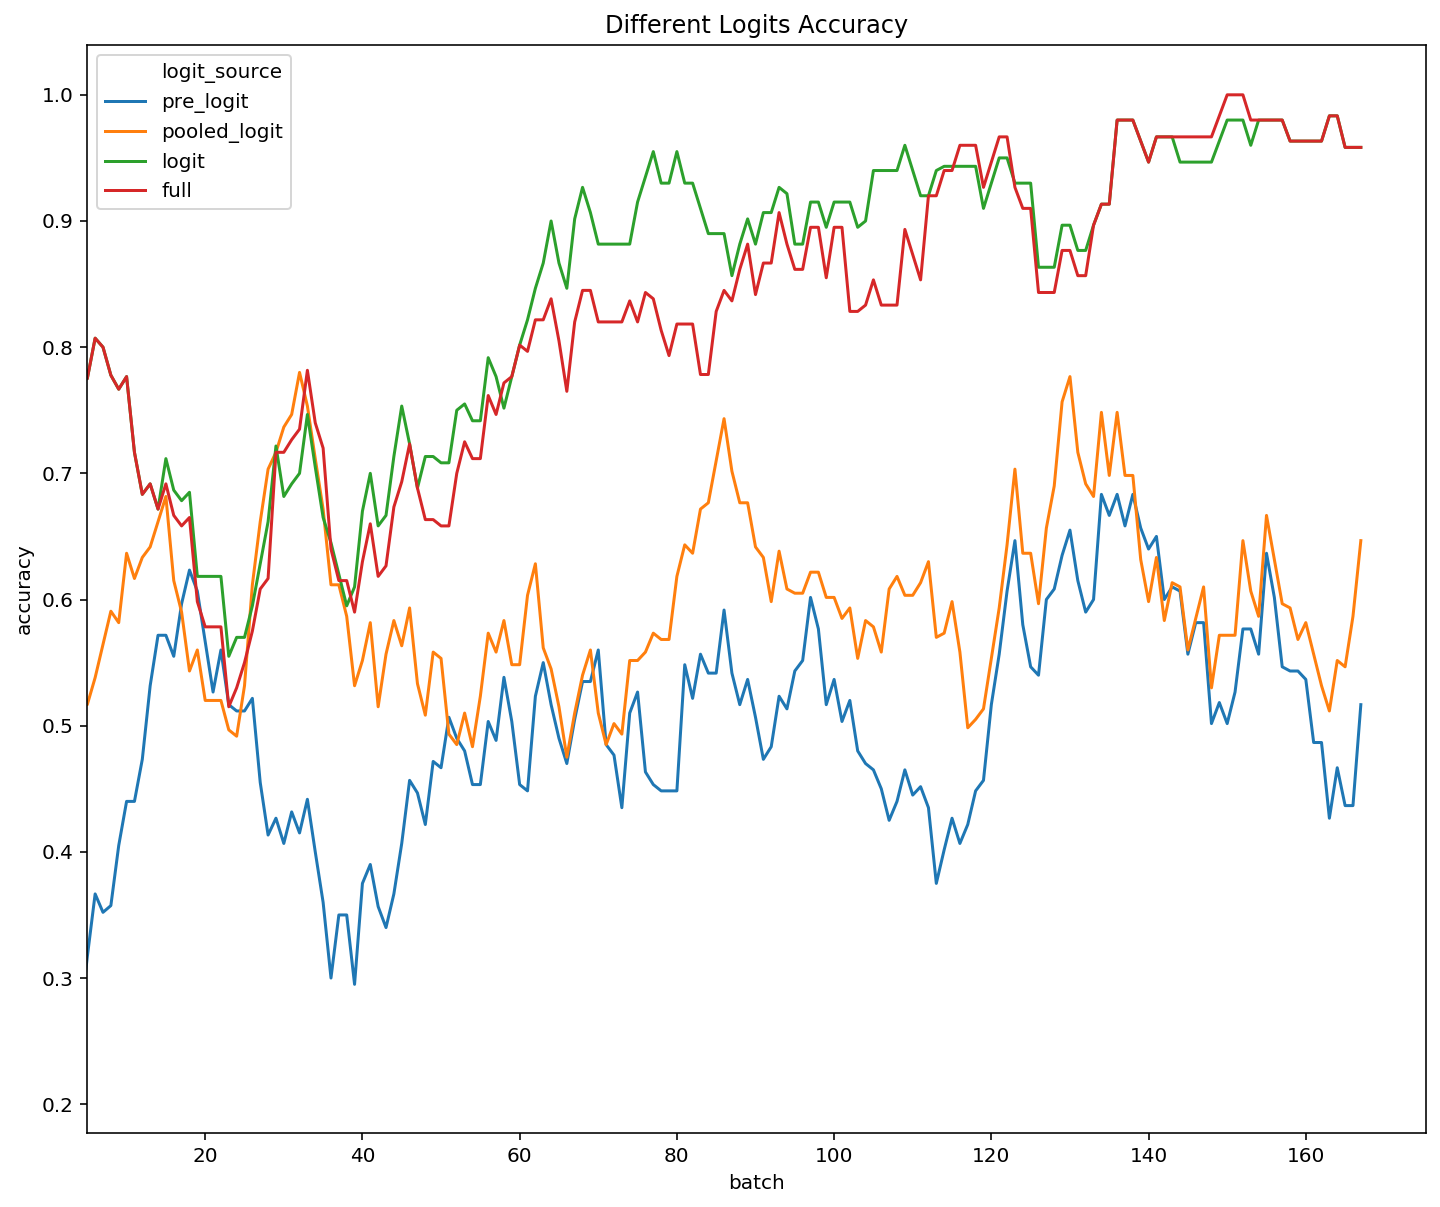

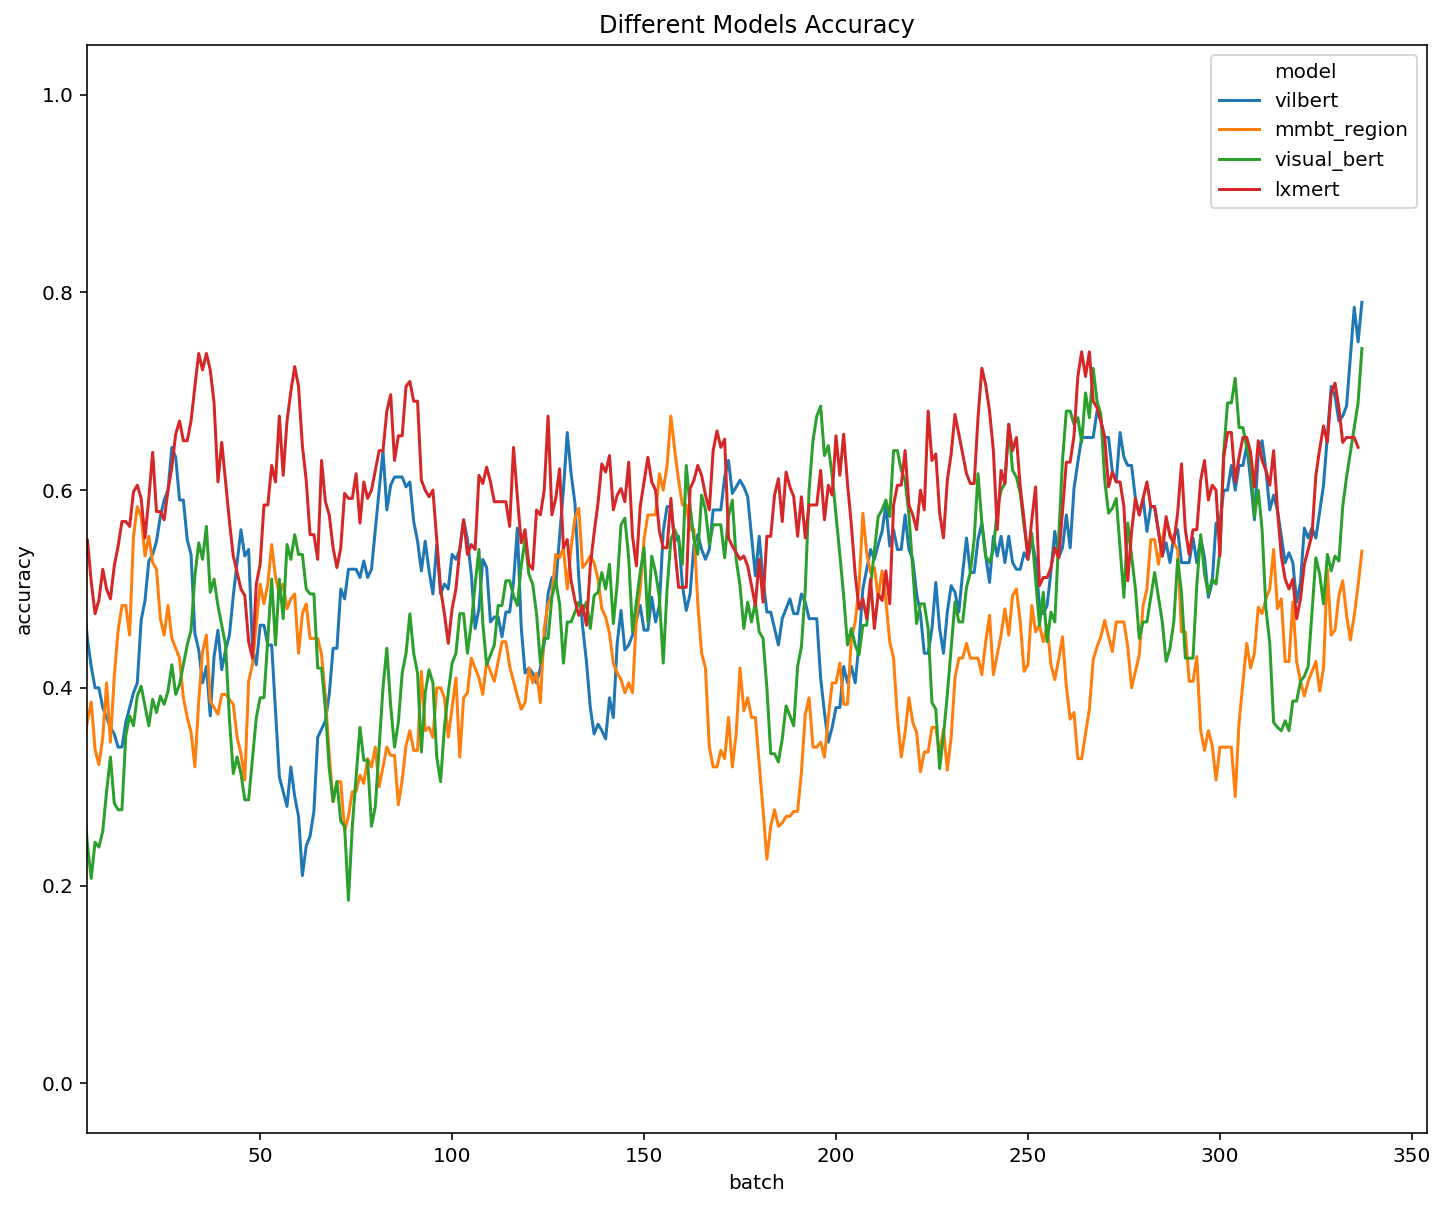

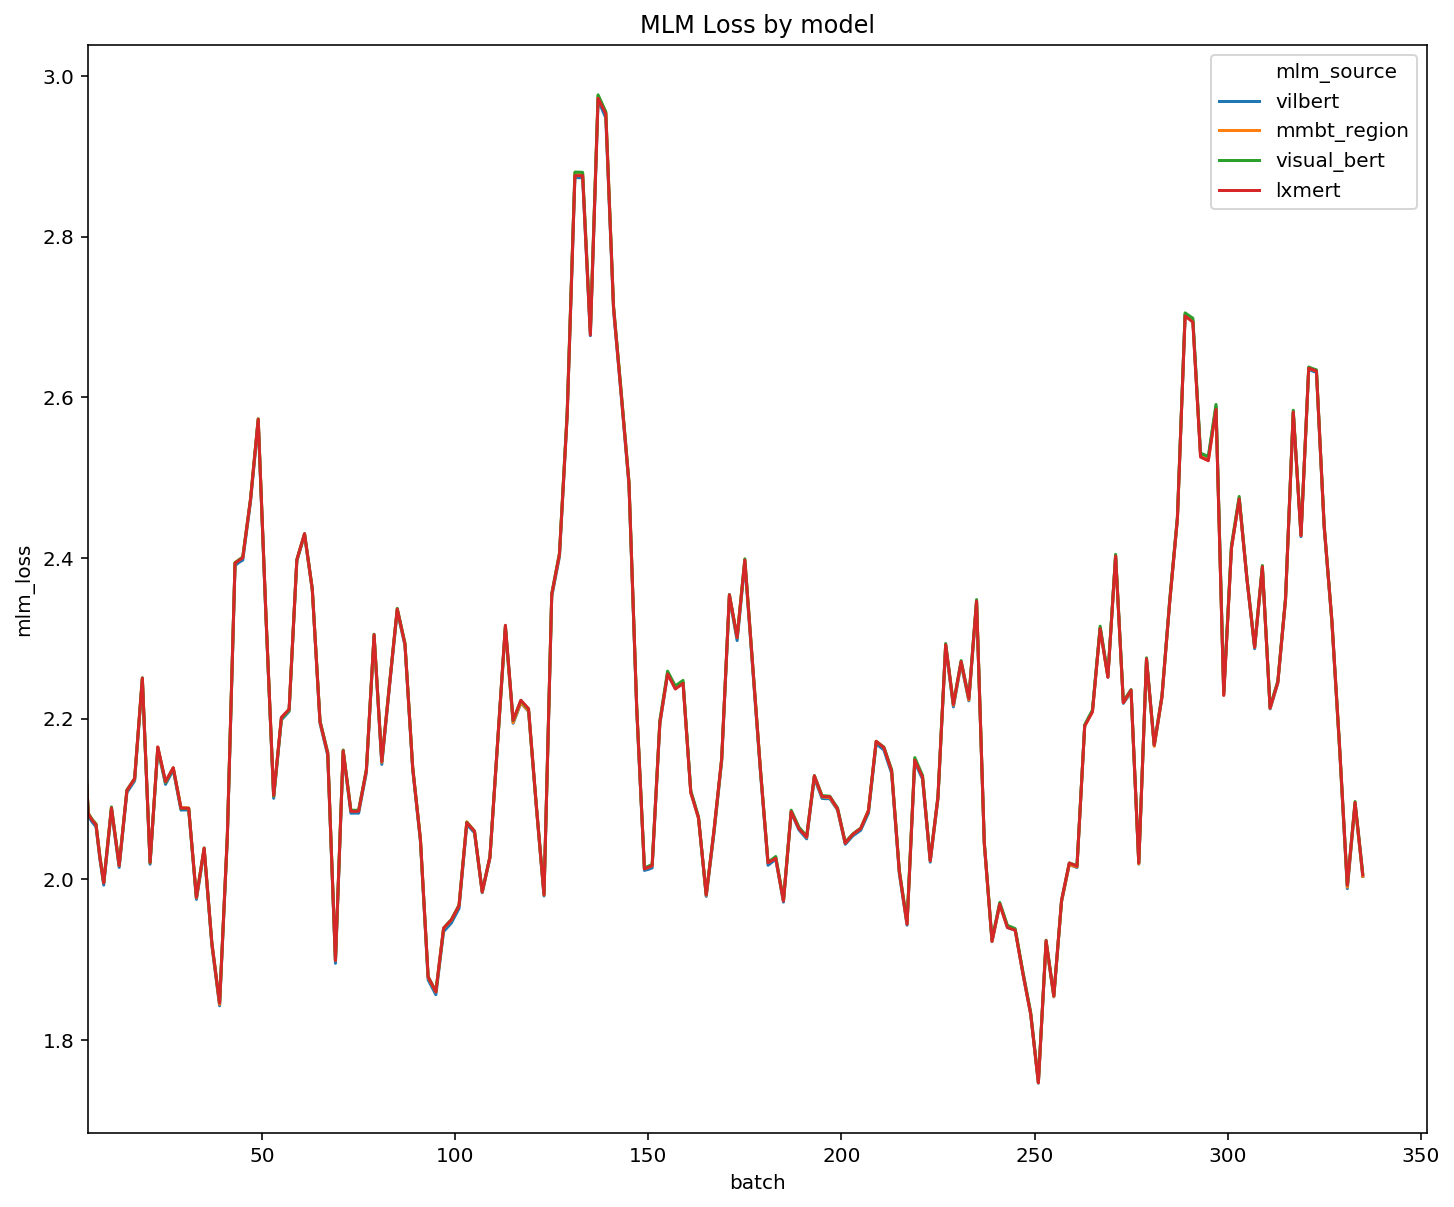

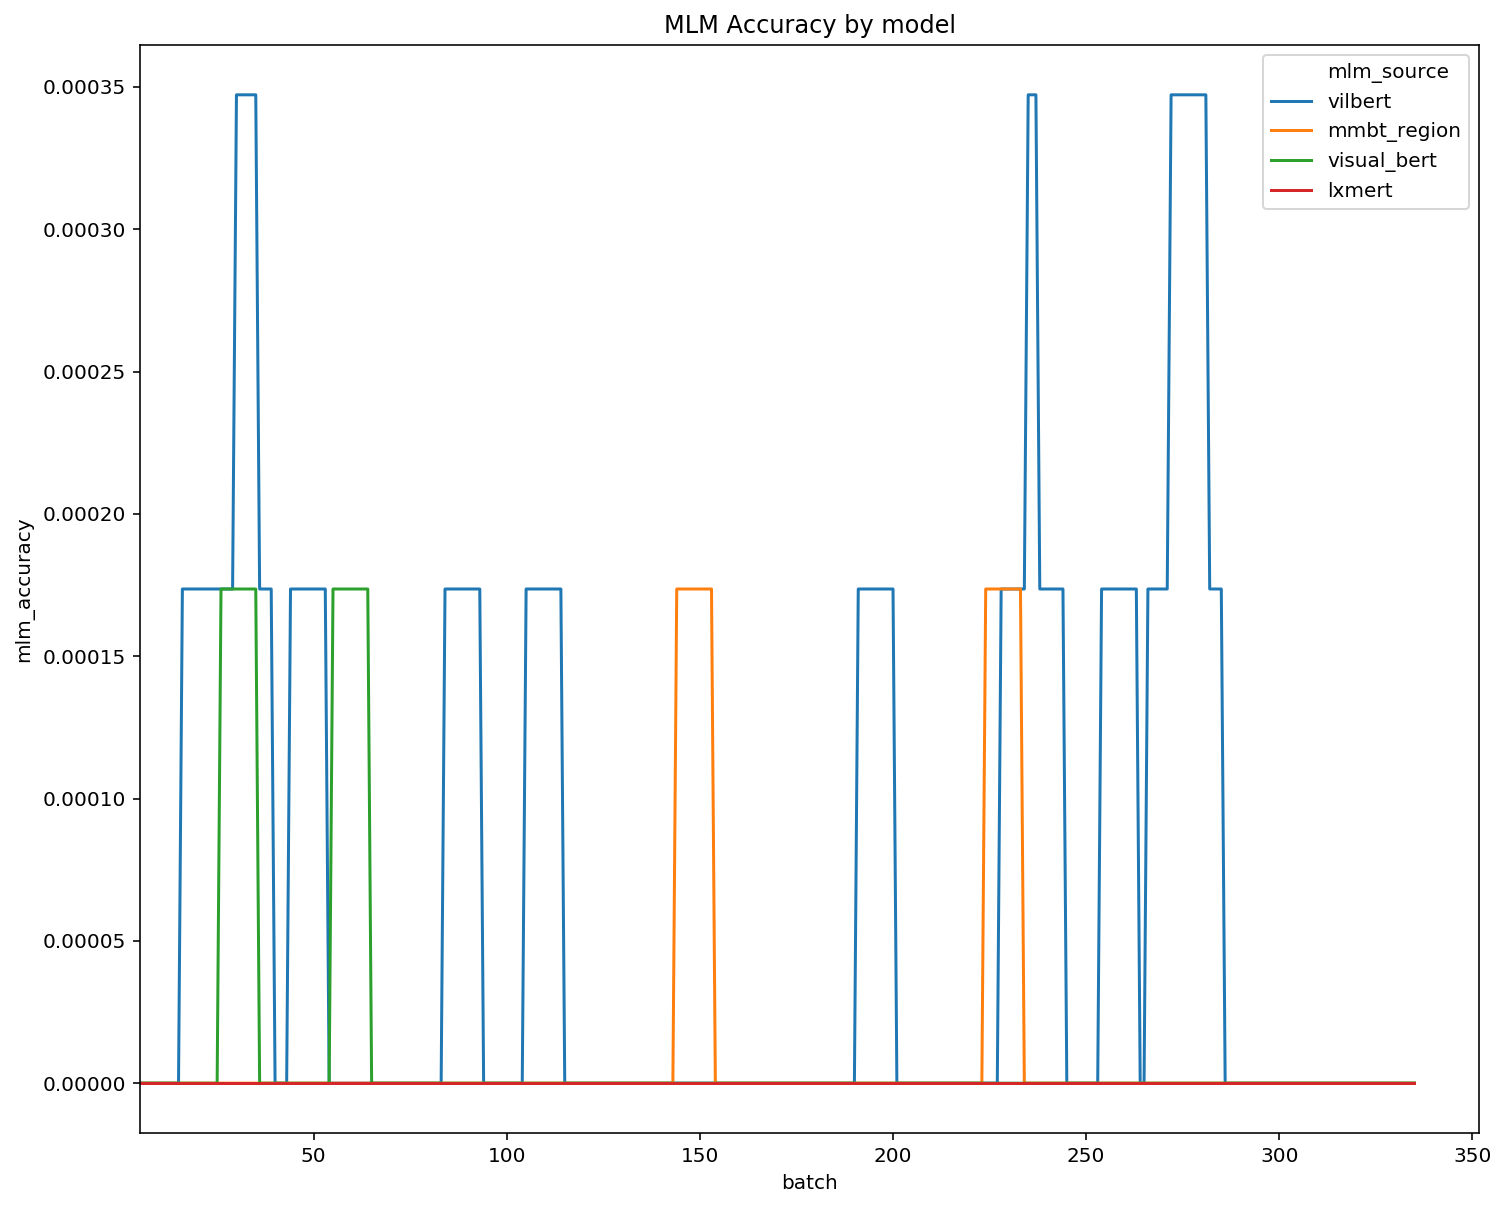

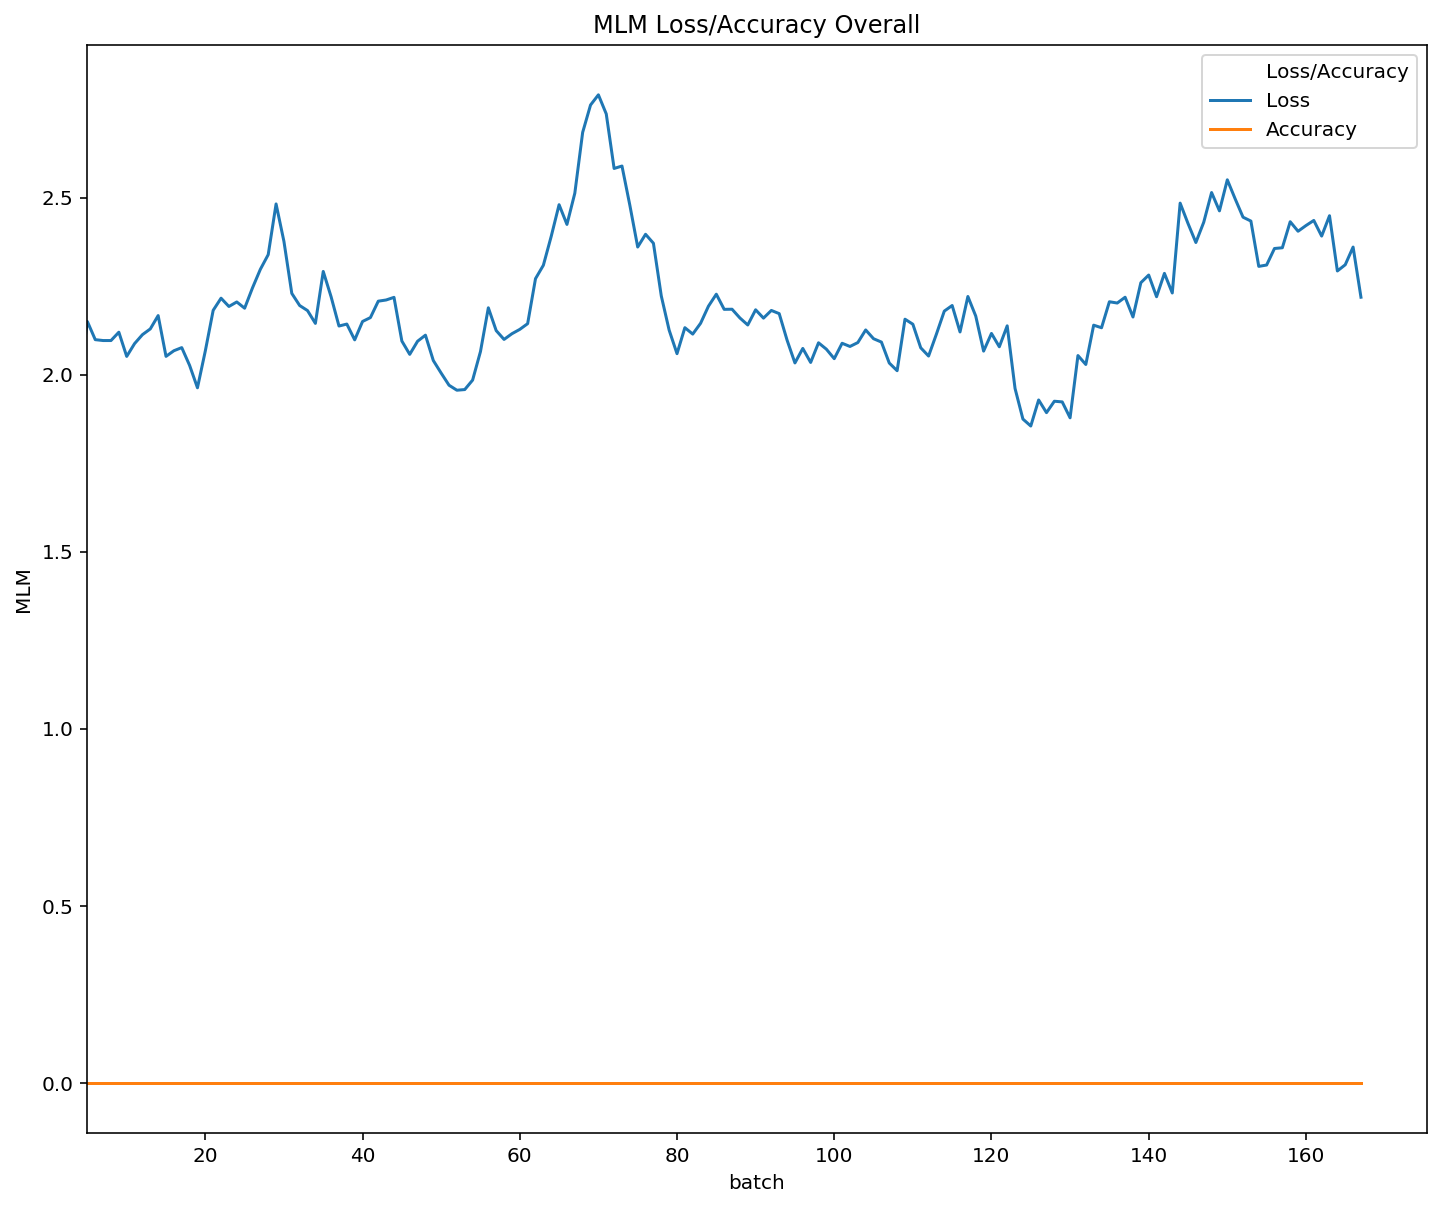

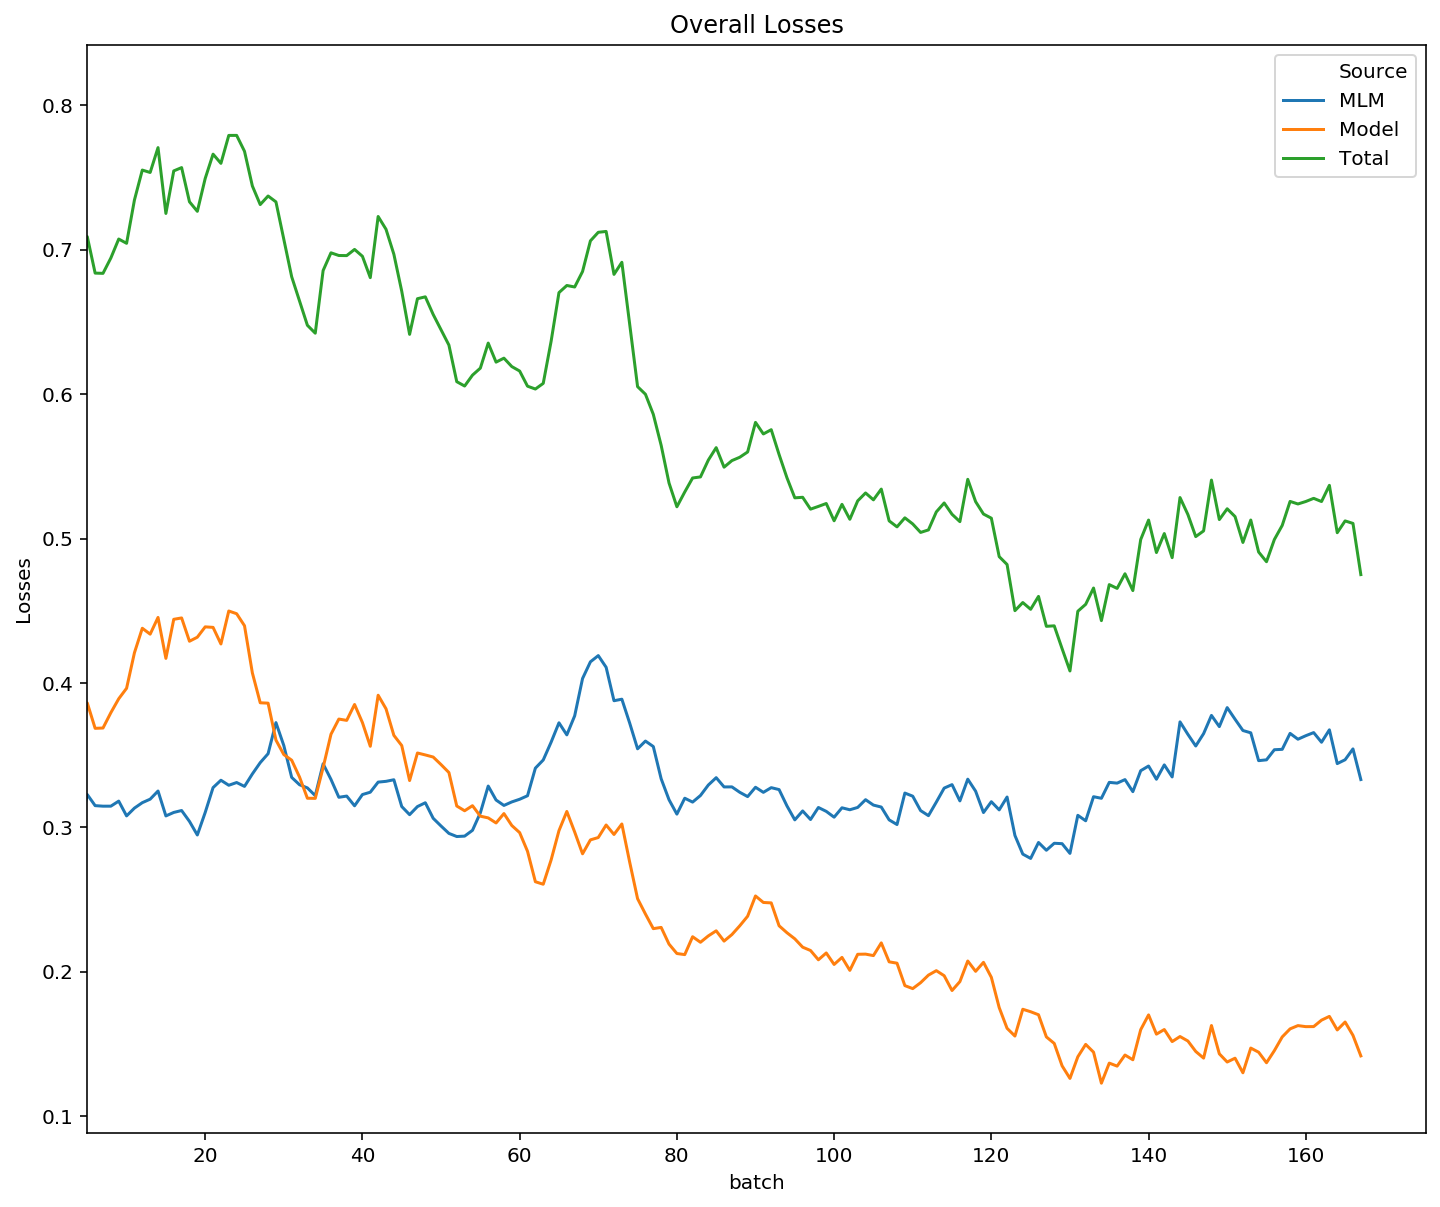

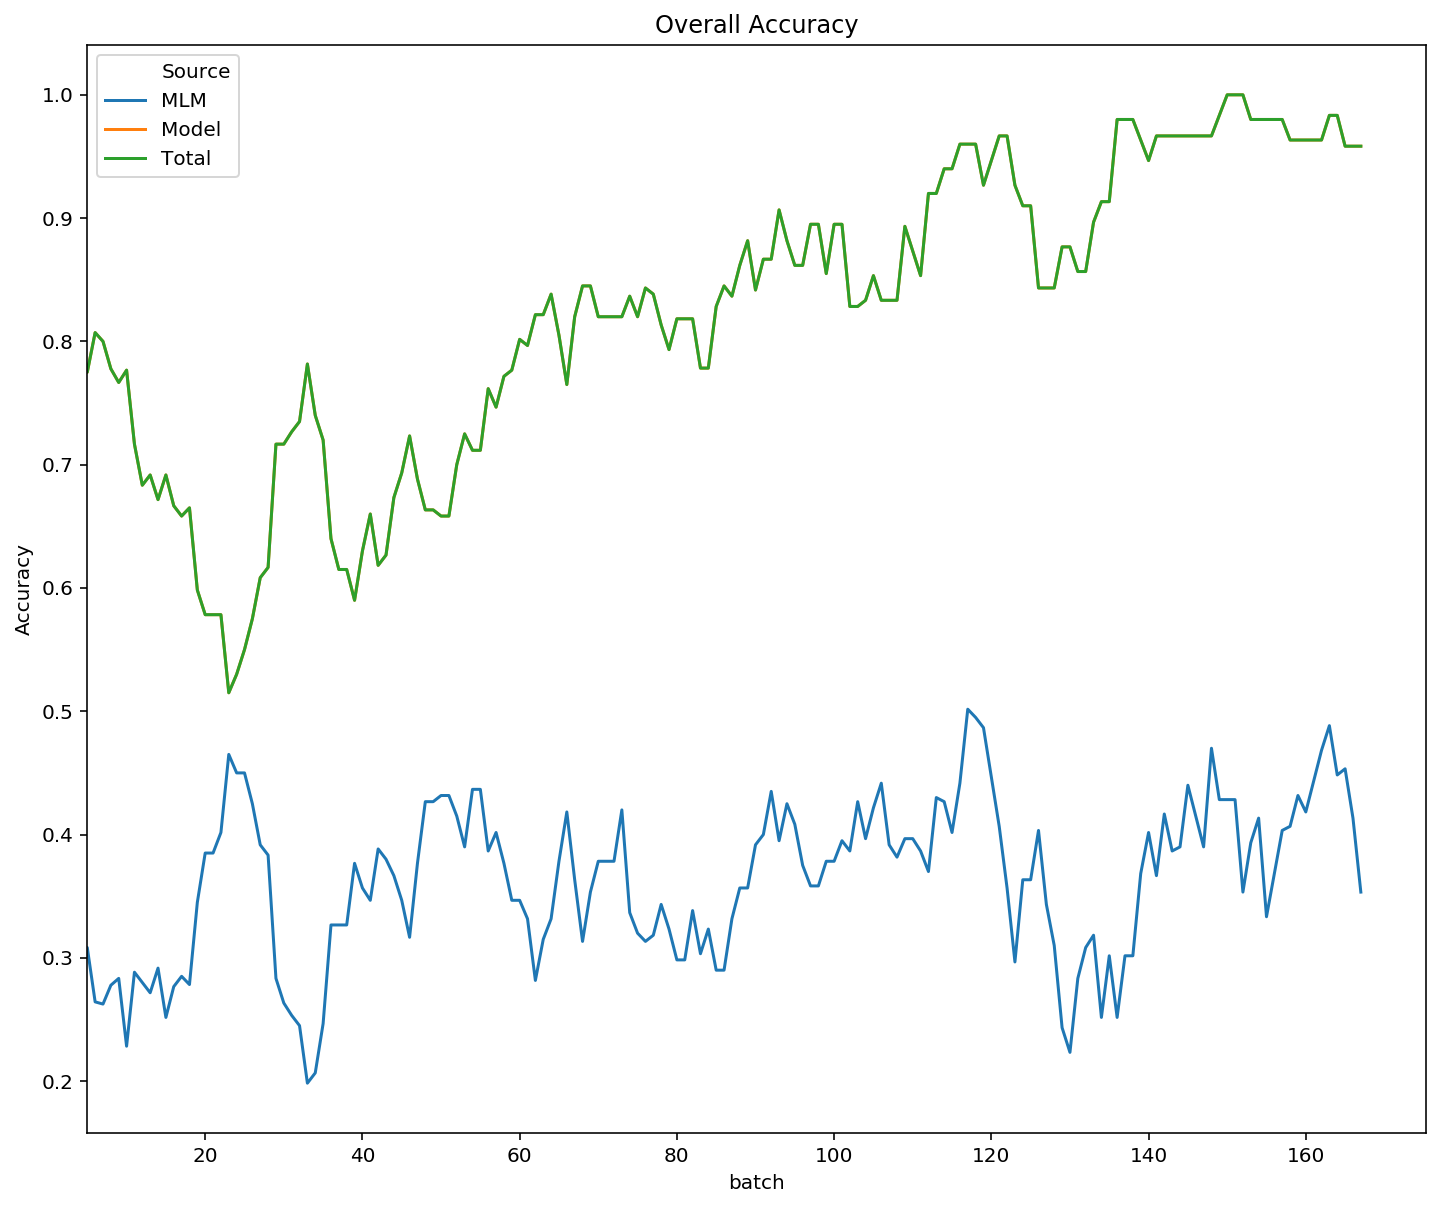

In [19]:
make_plots(model, mlm_model, logy=False, exclude_from_start=5, smoothing=10)

# Single Eval

## Validate

In [15]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev'], data["metadata"], False)
validate(mlm_model, batch_size, dev_dataset, display_detail=True)


Proba       Preds    
         min   max   min max
Labels                      
0      0.450 0.490     0   0
1      0.491 0.532     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.454,"[0.5464596152305603, 0.4535403251647949]",0,0,0.503,"[0.4972197711467743, 0.5027801990509033]",1,1,0.453,"[0.547242283821106, 0.45275771617889404]",0,0
1,0.504,"[0.495943158864975, 0.5040568113327026]",1,1,0.453,"[0.5467209815979004, 0.4532790184020996]",0,0,0.456,"[0.5441054701805115, 0.45589447021484375]",0,0
2,0.463,"[0.5372597575187683, 0.4627402126789093]",0,0,0.452,"[0.5476936101913452, 0.4523063898086548]",0,0,0.500,"[0.4998438358306885, 0.5001561641693115]",1,1
3,0.453,"[0.5465977191925049, 0.4534023106098175]",0,0,0.473,"[0.5274225473403931, 0.47257739305496216]",0,0,0.454,"[0.5462452173233032, 0.4537547528743744]",0,0
4,0.454,"[0.5459616184234619, 0.4540383815765381]",0,0,0.454,"[0.5456727147102356, 0.45432722568511963]",0,0,0.510,"[0.4899140000343323, 0.5100859999656677]",1,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,253,0,253.000,100.000
1,61,186,247.000,75.000
Predicted Counts,314,186,500.000,nan
Precision %,80,100,nan,nan


scores =  {'map': '1.0000', 'acc': '0.8780', 'auc': '1.0000'}


([1.0, 0.878, 1.0],
 (array([0.80573248, 1.        ]),
  array([1.        , 0.75303644]),
  array([0.89241623, 0.8591224 ]),
  array([253, 247])))

In [17]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False)
validate(mlm_model, batch_size, dev_dataset, display_detail=True)


Proba       Preds    
         min   max   min max
Labels                      
0      0.444 0.486     0   0
1      0.479 0.526     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.454,"[0.5460750460624695, 0.45392492413520813]",0,0,0.480,"[0.5197834968566895, 0.48021647334098816]",0,0,0.457,"[0.5426756739616394, 0.4573242962360382]",0,0
1,0.450,"[0.5498451590538025, 0.4501548409461975]",0,0,0.460,"[0.5397024154663086, 0.4602976143360138]",0,0,0.449,"[0.5512627959251404, 0.448737233877182]",0,0
2,0.452,"[0.547602653503418, 0.4523973762989044]",0,0,0.488,"[0.5120773911476135, 0.4879225790500641]",0,1,0.450,"[0.5502782464027405, 0.4497217833995819]",0,0
3,0.489,"[0.5113470554351807, 0.48865291476249695]",0,1,0.457,"[0.5426756739616394, 0.4573242962360382]",0,0,0.451,"[0.5491551160812378, 0.4508448541164398]",0,0
4,0.449,"[0.5507445931434631, 0.44925546646118164]",0,0,0.449,"[0.5509055256843567, 0.4490944445133209]",0,0,0.449,"[0.5512492656707764, 0.44875070452690125]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,340,0,340.000,100.000
1,110,90,200.000,45.000
Predicted Counts,450,90,540.000,nan
Precision %,75,100,nan,nan


scores =  {'map': '0.9990', 'acc': '0.7963', 'auc': '0.9994'}


([0.9990178938066154, 0.7962962962962963, 0.9994264705882353],
 (array([0.75555556, 1.        ]),
  array([1.  , 0.45]),
  array([0.86075949, 0.62068966]),
  array([340, 200])))

In [18]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False)
validate(model, batch_size, dev_dataset, display_detail=True)


Proba       Preds    
         min   max   min max
Labels                      
0      0.446 0.518     0   1
1      0.451 0.522     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.465,"[0.534820556640625, 0.465179443359375]",0,0,0.458,"[0.5421531796455383, 0.4578467905521393]",0,0,0.463,"[0.5374876856803894, 0.4625122845172882]",0,0
1,0.464,"[0.5362177491188049, 0.4637822210788727]",0,0,0.480,"[0.51964271068573, 0.48035722970962524]",0,1,0.484,"[0.5163006782531738, 0.48369932174682617]",0,0
2,0.500,"[0.49979931116104126, 0.500200629234314]",1,0,0.460,"[0.5398190021514893, 0.46018096804618835]",0,1,0.459,"[0.5405648350715637, 0.45943525433540344]",0,1
3,0.464,"[0.536426305770874, 0.46357372403144836]",0,0,0.474,"[0.5256192088127136, 0.47438082098960876]",0,1,0.457,"[0.5433014631271362, 0.45669856667518616]",0,0
4,0.456,"[0.5436679720878601, 0.45633193850517273]",0,1,0.492,"[0.5083308815956116, 0.4916692078113556]",0,1,0.454,"[0.5463870167732239, 0.45361292362213135]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,328,12,340.000,96.000
1,187,13,200.000,6.000
Predicted Counts,515,25,540.000,nan
Precision %,63,52,nan,nan


scores =  {'map': '0.5635', 'acc': '0.6315', 'auc': '0.7170'}


([0.5635187200301754, 0.6314814814814815, 0.7170147058823529],
 (array([0.6368932, 0.52     ]),
  array([0.96470588, 0.065     ]),
  array([0.76725146, 0.11555556]),
  array([340, 200])))

## Predict

In [19]:
preds = predict(mlm_model, data, batch_size, competition_phase=1)


,id,proba,label
0,16395,0.461,0
1,37405,0.472,0
2,94180,0.467,0
3,54321,0.450,0
4,97015,0.473,0
...,...,...,...
995,3869,0.447,0
996,23817,0.444,0
997,56280,0.452,0
998,29384,0.449,0


In [ ]:
preds = predict(model, data, batch_size, competition_phase=1)


In [25]:
preds.to_csv("submission_phase_1.csv", index=False)

# Multi-eval
- Use back-translation
    - Longest 3 backtranslation
- Use imgaug
    - identity
    - HFlip
    - GrayScale
    - GridDrop
    
- Use word replace
    - Replace top 2 longest word
- Use `[masking]`
    - 0.15 mask rate `5` times
- identity text
    
(5+3+3)*4 = 44
